In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
cd "D:\Depaul\DATA_SCIENCE\prog_ml_apps\DATASET\archive (5)"


D:\Depaul\DATA_SCIENCE\prog_ml_apps\DATASET\archive (5)


In [3]:
data = pd.read_csv('Data_Entry_2017.csv')

my_glob = glob('images*/images/*.png')

# Step 2: Map image basenames to their absolute paths
all_image_paths = {os.path.basename(x): x for x in my_glob}

print('Scans found:', len(all_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(all_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x[:-1])if isinstance(x, str)else x)
data.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
48190,00012219_002.png,No Finding,2,12219,67,F,AP,2500,2048,0.168,0.168,NaN,images_006\images\00012219_002.png
93624,00023520_003.png,No Finding,3,23520,56,M,PA,2992,2991,0.143,0.143,NaN,images_010\images\00023520_003.png
52989,00013367_000.png,No Finding,0,13367,48,M,PA,2992,2991,0.143,0.143,NaN,images_006\images\00013367_000.png


In [4]:
# Assuming `data` is already loaded
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', '') if pd.notnull(x) else '')
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label) > 1:  # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
39919,00010430_001.png,,1,10430,56,M,PA,2674,2991,0.143,0.143,NaN,images_005\images\00010430_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28787,00007522_001.png,,1,7522,68,F,PA,2048,2500,0.168,0.168,NaN,images_004\images\00007522_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87658,00021663_002.png,,2,21663,21,M,PA,2990,2991,0.143,0.143,NaN,images_010\images\00021663_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
MIN_CASES = 1000
#all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
all_labels = ['Effusion', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax']

print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])

Clean Labels (6) [('Effusion', 13317), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Atelectasis', 11559), ('Pneumothorax', 5302)]


In [7]:
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x) > 0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(100000, weights=sample_weights, replace=True)

In [8]:
# Dropping unnecessary columns
columns_to_drop = ['Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 
                   'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']
data = data.drop(columns=[col for col in columns_to_drop if col in data])


In [9]:
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

counts = data['Finding Labels'].value_counts()
mask = data['Finding Labels'].isin(counts[counts >= 251].index)
data = data[mask]

threshold = 0.75
category_to_delete = ''  # Add appropriate category to delete

# Select rows with the specified category
category_rows = data[data['Finding Labels'] == category_to_delete]

# Calculate the number of rows to delete
num_rows_to_delete = int(len(category_rows) * threshold)

# Randomly select rows to delete
rows_to_delete = np.random.choice(category_rows.index, size=num_rows_to_delete, replace=False)


In [10]:
# Delete selected rows from the DataFrame
data = data.drop(rows_to_delete)

train_df, valid_df = train_test_split(data, test_size=0.25, random_state=2018, stratify=data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 57457 validation 19153


In [11]:
# Calculate the sum of diseases per patient
train_df['Total Diseases'] = train_df[all_labels].sum(axis=1)

# Filter patients with exactly one disease
one_disease_df = train_df[train_df['Total Diseases'] == 1]

In [12]:
one_disease_df

,Image Index,Finding Labels,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec,Total Diseases
84815,00020900_007.png,Infiltration,images_009\images\00020900_007.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0
57327,00014223_010.png,Edema|Infiltration|Pneumonia,images_007\images\00014223_010.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0
84125,00020673_047.png,Infiltration,images_009\images\00020673_047.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0
51573,00013031_008.png,Emphysema|Infiltration,images_006\images\00013031_008.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0
86690,00021377_017.png,Atelectasis,images_010\images\00021377_017.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34537,00009096_001.png,Infiltration,images_004\images\00009096_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0
69147,00017062_000.png,Infiltration,images_008\images\00017062_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0
77987,00019150_005.png,Infiltration,images_009\images\00019150_005.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0
64209,00015843_003.png,Consolidation|Nodule,images_007\images\00015843_003.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",1.0


In [20]:

"""
### for testting purpose 10 iages per each class
# Function to sample 10 images per class
def sample_images_per_class(df, labels, num_samples=10):
    sampled_df = pd.DataFrame()
    for label in labels:
        label_df = df[df[label] == 1]
        sampled_label_df = label_df.sample(min(num_samples, len(label_df)))
        sampled_df = pd.concat([sampled_df, sampled_label_df])
    return sampled_df

train_df = sample_images_per_class(one_disease_df, all_labels, num_samples=10)
valid_df = sample_images_per_class(valid_df, all_labels, num_samples=10)
print('Sampled train', train_df.shape[0], 'Sampled validation', valid_df.shape[0])

"""

Sampled train 60 Sampled validation 60


In [21]:
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip=True, 
                              vertical_flip=False, 
                              height_shift_range=0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range=0.1,
                              fill_mode='reflect',
                              zoom_range=0.15)

In [22]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                              class_mode='sparse',
                                              **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''  # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [23]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
one_disease_df['newLabel'] = one_disease_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [24]:
train_gen = core_idg.flow_from_dataframe(dataframe=one_disease_df,
                                         directory=None,
                                         x_col='path',
                                         y_col='newLabel',
                                         class_mode='categorical',
                                         classes=all_labels,
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         batch_size=32)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                         directory=None,
                                         x_col='path',
                                         y_col='newLabel',
                                         class_mode='categorical',
                                         classes=all_labels,
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         batch_size=256)  # we can use much larger batches for evaluation

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                   directory=None,
                                                   x_col='path',
                                                   y_col='newLabel',
                                                   class_mode='categorical',
                                                   classes=all_labels,
                                                   target_size=IMG_SIZE,
                                                   color_mode='rgb',
                                                   batch_size=1024))

Found 31301 validated image filenames belonging to 6 classes.
Found 60 validated image filenames belonging to 6 classes.
Found 60 validated image filenames belonging to 6 classes.


In [25]:
t_x, t_y = next(train_gen)

In [26]:
def dense_block(x, blocks):
    for _ in range(blocks):
        x1 = layers.BatchNormalization()(x)
        x1 = layers.Activation('relu')(x1)
        x1 = layers.Conv2D(32, kernel_size=3, padding='same')(x1)
        x = layers.Concatenate()([x, x1])
    return x

def transition_block(x):
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, kernel_size=1, padding='same')(x)
    x = layers.AveragePooling2D(pool_size=2, strides=2)(x)
    return x

def create_densenet121(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = dense_block(x, 6)
    x = transition_block(x)

    x = dense_block(x, 12)
    x = transition_block(x)

    x = dense_block(x, 24)
    x = transition_block(x)

    x = dense_block(x, 16)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [27]:
# Define input shape and number of classes
input_shape = (128, 128, 3)

# Create the model
model = create_densenet121(input_shape, len(all_labels))

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 64, 64, 64)        │           9,472 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64, 64, 64)        │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 64, 64, 64)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 32, 32, 64)        │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 32, 64)        │             256 │ max_pooling2d[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 32, 32, 64)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 32, 32, 32)        │          18,464 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 32, 32, 96)        │               0 │ max_pooling2d[0][0],       │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 32, 32, 96)        │             384 │ concatenate[0][0]          │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 32, 32, 96)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 32, 32, 32)        │          27,680 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 32, 32, 128)       │               0 │ concatenate[0][0],         │
│                               │                           │                 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 32, 32, 128)       │             512 │ concatenate_1[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 6,750,790 (25.75 MB)

 Trainable params: 6,701,446 (25.56 MB)

 Non-trainable params: 49,344 (192.75 KB)

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy', 'mae'])

from keras.callbacks import ModelCheckpoint, EarlyStopping

weight_path = "xray_class_weights.best.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks_list = [checkpoint, early]

In [29]:
type(train_gen)

keras.src.legacy.preprocessing.image.DataFrameIterator

In [41]:
# Train the model
model.fit(train_gen, validation_data=valid_gen, epochs=50, callbacks=callbacks_list)

Epoch 1/50


C:\Users\samee\anaconda3\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.1381 - loss: 4.9602 - mae: 0.1927
Epoch 1: val_loss improved from inf to 12.30357, saving model to xray_class_weights.best.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.1369 - loss: 4.9597 - mae: 0.1925 - val_categorical_accuracy: 0.0462 - val_loss: 12.3036 - val_mae: 0.2087
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.1143 - loss: 4.5538 - mae: 0.1821
Epoch 2: val_loss did not improve from 12.30357
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - categorical_accuracy: 0.1106 - loss: 4.5463 - mae: 0.1820 - val_categorical_accuracy: 0.0462 - val_loss: 27.7646 - val_mae: 0.2085
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.0920 - loss: 4.3590 - mae: 0.1793   
Epoch 3: val_loss did not improve from 12.30357
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - categorical_accuracy: 0.0920 - loss: 4.3790 - mae: 0.1795 - val_categorical_accuracy: 0.0462 - val_loss: 52.3765

In [30]:
# Predicting and calculating the metrics
pred_Y = model.predict(test_X, batch_size=32, verbose=True)
pred_labels = np.argmax(pred_Y, axis=1)
true_labels = np.argmax(test_Y, axis=1)

precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Precision: 0.060248181429182715
Recall: 0.16666666666666666
F1 Score: 0.08602564102564102


C:\Users\samee\anaconda3\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


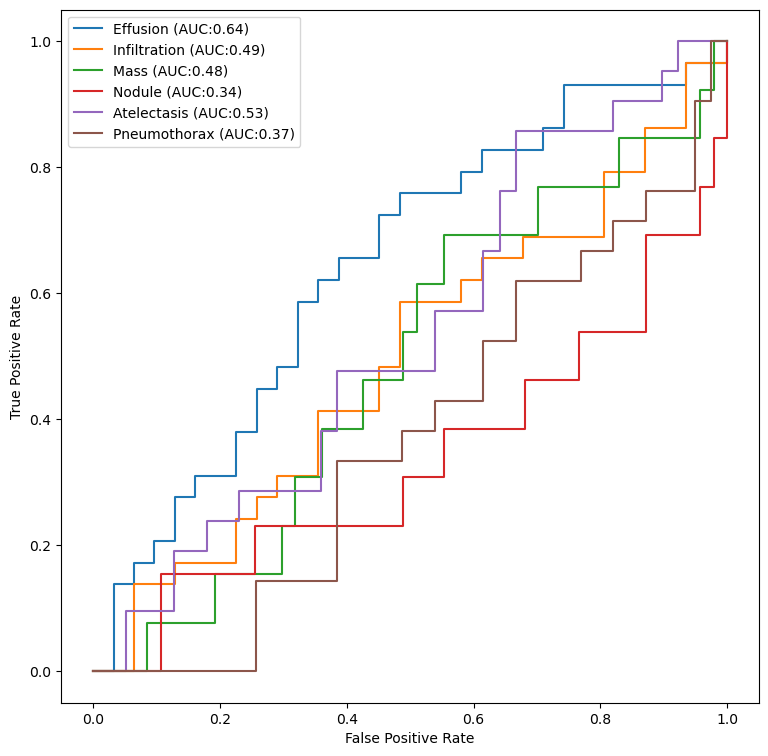

In [31]:
# Plotting ROC Curves
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), pred_Y[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')